# 项目报告：基于演化博弈论的群体策略生存模拟

学生：李齐家 |专业：数学与应用数学|年级： 大一

## **1. 项目背景**

为了探究在竞争激烈的社会环境中，何种策略具备“进化稳定性” (Evolutionarily Stable Strategy)。模拟场景为重复囚徒困境 (Iterated Prisoner's Dilemma)，引入了优胜劣汰的进化机制。

## **2. 实验设置**

种群规模：100 个体
初始分布：1/3 背叛者 (Defector), 1/3 合作者 (Cooperator), 1/3 以牙还牙者 (Tit-For-Tat)
收益矩阵：
(合作, 合作) => 3分
(背叛, 背叛) => 1分
(背叛, 合作) => 5分 (背叛者暴利)
演化逻辑：每代淘汰得分最低的 20%，并由得分最高的 20% 繁殖后代。

## **3. 代码实现与结果分析**

以下为核心仿真代码及种群演化可视化结果。

Simulation Started: 10000 agents, 100 generations.
Simulation complete. Displaying results...


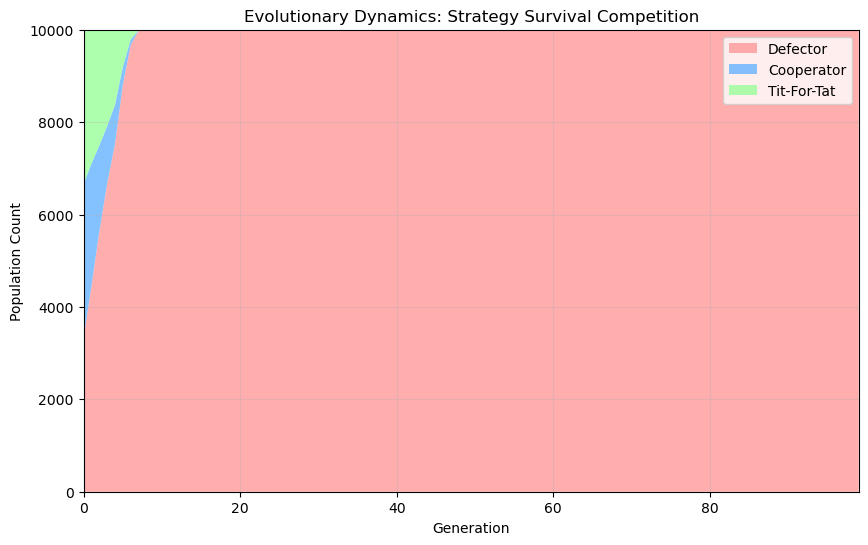

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ==========================================
# 1. 基础配置与规则定义
# ==========================================

# 模拟参数
GENERATIONS = 10       # 演化代数
POPULATION_SIZE = 100  # 种群总数
ROUNDS_PER_GAME = 10   # 每一对玩家博弈的回合数

# 格式：(我出的牌, 对手出的牌): 我得到的收益
# 1 = 合作 (Cooperate), 0 = 背叛 (Defect)
# 数值设定遵循囚徒困境标准：T(5) > R(3) > P(1) > C(0)
PAYOFF = {
    (1, 1): 3,  # Reward: 双方合作
    (0, 0): 1,  # Punishment: 双方背叛
    (0, 1): 5,  # Temptation: 我背叛，对手合作
    (1, 0): 0   # Cheat: 我合作，对手背叛
}

# ==========================================
# 2. 玩家类定义 (Agent Class)
# ==========================================
class Player:
    def __init__(self, strategy_name):
        self.strategy = strategy_name  # 策略名称: Defector, Cooperator, Tit-For-Tat
        self.score = 0                 
    def play(self, opponent_history):
        """
        #根据博弈历史决定这一轮的动作。
        """
        ARGUMENT:
            opponent_history: 对手过去的出牌记录
        Returns:
            int: 1 (合作) 或 0 (背叛)
         
        # 策略 1: 永远背叛 (Defector)
        # 代表完全自私的个体
        if self.strategy == "Defector":
            return 0 
            
        # 策略 2: 永远合作 (Cooperator)
        # 代表完全利他的个体
        elif self.strategy == "Cooperator":
            return 1 
            
        # 策略 3: 以牙还牙 (Tit-For-Tat)
        # 著名的互惠利他策略：第一步合作，之后复制对手上一步的动作
        elif self.strategy == "Tit-For-Tat":
            if not opponent_history: #防止第一局没有return而报错
                return 1 # 初始友善
            return opponent_history[-1] # 随后模仿对手上一次行动
            
        return 1

# ==========================================
# 3. 演化模拟引擎 (Evolution Engine)
# ==========================================
def run_simulation():
    """
    执行完整的演化过程：初始化 -> 博弈 -> 筛选 -> 繁殖 -> 统计
    """
    # --- Step 1: 初始化种群 ---
    # 初始状态下，三种策略各占约 1/3
    population = []
    initial_strategies = ["Defector", "Cooperator", "Tit-For-Tat"]
    
    for strategy in initial_strategies:
        count = POPULATION_SIZE // 3
        for _ in range(count): #下划线是省略了i这个变量因为后续根本不用
            population.append(Player(strategy))
            
    # 补齐剩余个体
    while len(population) < POPULATION_SIZE:
        population.append(Player("Tit-For-Tat"))

    # 用于记录每一代的数据，供后续 Matplotlib 画图
    history_data = {"Defector": [], "Cooperator": [], "Tit-For-Tat": []}

    print(f"Simulation Started: {POPULATION_SIZE} agents, {GENERATIONS} generations.")

    # --- Step 2: 代际循环 ---
    for gen in range(GENERATIONS):
        # 归零上一代的得分 (Reset scores)
        for p in population: 
            p.score = 0
        
        # 打乱顺序，进行随机两两配对
        random.shuffle(population)
        
        # 遍历配对 (Pairwise Interaction)
        for i in range(0, len(population) - 1, 2):
            p1 = population[i]
            p2 = population[i+1]
            
            h1, h2 = [], [] # 记录本局历史
            
            # 进行多轮博弈
            for _ in range(ROUNDS_PER_GAME):
                action1 = p1.play(h2)
                action2 = p2.play(h1)
                
                # 根据收益矩阵更新适应度 (Fitness Update)
                p1.score += PAYOFF[(action1, action2)]
                p2.score += PAYOFF[(action2, action1)]
                
                h1.append(action1)
                h2.append(action2)
        
        # --- Step 3: 数据统计 ---
        current_counts = {"Defector": 0, "Cooperator": 0, "Tit-For-Tat": 0}
        for p in population:
            current_counts[p.strategy] += 1
        
        for strat in history_data:
            history_data[strat].append(current_counts[strat])
            
        # --- Step 4: 优胜劣汰 (Natural Selection) ---
        # 按照得分(适应度)从高到低排序
        population.sort(key=lambda x: x.score, reverse=True)
        
        # 设定淘汰率：末位 20% 淘汰
        cutoff_index = int(POPULATION_SIZE * 0.2)
        
        # 保留前 80% (Survivors)
        survivors = population[:-cutoff_index]
        
        # 繁殖前 20% (Elites Reproduce)
        # 逻辑：高分个体的策略更容易传播给后代
        elites = population[:cutoff_index]
        babies = []
        for parent in elites:
            # 复制父母的策略
            babies.append(Player(parent.strategy))
            
        # 新一代种群 = 幸存者 + 新生儿
        population = survivors + babies

    return history_data

# ==========================================
# 4. 可视化结果 (Visualization)
# ==========================================
if __name__ == "__main__":
    # 运行模拟
    results = run_simulation()

    # 使用 Matplotlib 绘制堆叠面积图 (Stackplot)
    generations = range(GENERATIONS)
    plt.figure(figsize=(10, 6))
    
    plt.stackplot(generations, 
                  results["Defector"], 
                  results["Cooperator"], 
                  results["Tit-For-Tat"],
                  labels=["Defector", "Cooperator", "Tit-For-Tat"],
                  colors=['#ff9999','#66b3ff','#99ff99'], 
                  alpha=0.8)
    
    plt.title("Evolutionary Dynamics: Strategy Survival Competition")
    plt.xlabel("Generation")
    plt.ylabel("Population Count")
    plt.legend(loc='upper right')
    plt.margins(0, 0)
    plt.grid(alpha=0.3)
    
    print("Simulation complete. Displaying results...")
    plt.show()